In [15]:
import string
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import SGD

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import fasttext
import fasttext.util
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')

### Veri Okuma

In [24]:
halk_dataset = pd.read_csv("../dataset/halk.csv", usecols=["sarki_sozu"])
sanat_dataset = pd.read_csv("../dataset/sanat.csv", usecols=["sarki_sozu"])
ilahi_dataset = pd.read_csv("../dataset/ilahi.csv", usecols=["sarki_sozu"])
pop_dataset = pd.read_csv("../dataset/pop.csv", usecols=["sarki_sozu"])
rock_dataset = pd.read_csv("../dataset/rock.csv", usecols=["sarki_sozu"])
rap_dataset = pd.read_csv("../dataset/rap.csv", usecols=["sarki_sozu"])

# Veri Etiketleme
halk_dataset["sarki_turu"] = [0 for _ in range(200)]
sanat_dataset["sarki_turu"] = [1 for _ in range(200)]
ilahi_dataset["sarki_turu"] = [2 for _ in range(200)]
pop_dataset["sarki_turu"] = [3 for _ in range(200)]
rock_dataset["sarki_turu"] = [4 for _ in range(200)]
rap_dataset["sarki_turu"] = [5 for _ in range(200)]

df_dataset = pd.concat([halk_dataset, sanat_dataset, ilahi_dataset, pop_dataset, rock_dataset, rap_dataset], axis=0, ignore_index=True)

df_dataset = df_dataset.reset_index(drop=True)

### Veri Önişleme

In [25]:
# Getting stop_words
my_file = open("../raw_data/stop_words.txt", "r")
stop_words = my_file.read()
stop_words = stop_words.replace('\n', ' ').split(" ")
my_file.close()

def clean_text(text):
    # Satır boşluklarının kaldırılması
    text = text.replace("\n\n", "\n")

    # Satır Sonlarındaki Boşlukların Kaldırılması
    lines = text.split("\n")
    temp_text = ""
    for line in lines:
        temp_text += line.rstrip() + "\n"
    text = temp_text

    # Noktalama İşaretlerinin Kaldırılması
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Küçük Harf Dönüşümü
    text = text.lower()

    # stop word'lerin kaldırılması
    lines = text.split('\n')
    for i, line in enumerate(lines):
        words = line.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        lines[i] = ' '.join(filtered_words)
    #text = '\n'.join(lines)
    text = ' '.join(lines)
    
    return text



df_dataset["sarki_sozu"] = [clean_text(lyrics) for lyrics in df_dataset.loc[:,"sarki_sozu"]]

In [26]:
train_df, test_df = train_test_split(df_dataset, test_size=0.2, random_state=42, shuffle=True)

In [5]:
print('loading word embeddings...')

embeddings_index = {}
fasttext_model = fasttext.load_model('cc.tr.300.bin/cc.tr.300.bin')
# embedding_dim = 100
# fasttext.util.reduce_model(ft, embedding_dim)
words = fasttext_model.get_words()
for word in tqdm(words):
    embeddings_index[word] = fasttext_model.get_word_vector(word)

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


100%|██████████| 2000000/2000000 [00:27<00:00, 73240.74it/s]

found 2000000 word vectors


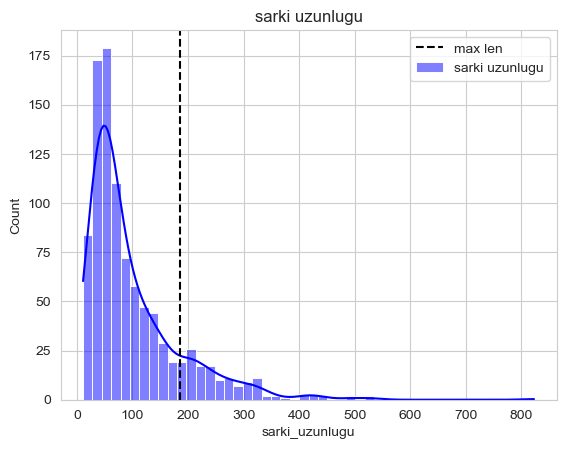

In [27]:
label_names = ["sarki_turu"]
y_train = train_df[label_names].values
train_df['sarki_uzunlugu'] = train_df['sarki_sozu'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['sarki_uzunlugu'].mean() + train_df['sarki_uzunlugu'].std()).astype(int)

sns.histplot(train_df['sarki_uzunlugu'], kde=True, color='b', label='sarki uzunlugu')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('sarki uzunlugu'); plt.legend()
plt.show()

In [28]:
from sklearn.utils import shuffle 

processed_docs_train = train_df['sarki_sozu'].tolist()
processed_docs_test = test_df['sarki_sozu'].tolist() 
num_classes = 6

print("pre-processing train data...")


print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...
tokenizing input data...
dictionary size:  26441


### Shape and Train with LSTM

In [29]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [30]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 3991


In [31]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['azana' 'doğmamışam' 'savamadım' 'turbüşon' 'gudurası' 'sürükleneceksin'
 'tâzelensin' 'gurşun' 'odalarıma' 'koymazdın']


In [13]:
y_train = to_categorical(y_train)

In [32]:
y_train.shape

(960, 1)

In [35]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) #model.add(Bidirectional(LSTM(32)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

"""model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 186, 300)          7932600   
                                                                 
 lstm_4 (LSTM)               (None, 128)               219648    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 8,160,894
Trainable params: 228,294
Non-trainable params: 7,932,600
_________________________________________________________________


"model = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))\nmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(6, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"

In [36]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=batch_size,
          epochs=num_epochs, validation_split=0.3, shuffle=False)

Epoch 1/40
3/3 [==============================] - 6s 1s/step - loss: 1.7907 - accuracy: 0.1905 - val_loss: 1.7860 - val_accuracy: 0.2257
Epoch 2/40
3/3 [==============================] - 3s 1s/step - loss: 1.7702 - accuracy: 0.2411 - val_loss: 1.7699 - val_accuracy: 0.2569
Epoch 3/40
3/3 [==============================] - 3s 1s/step - loss: 1.7422 - accuracy: 0.3185 - val_loss: 1.7405 - val_accuracy: 0.2500
Epoch 4/40
3/3 [==============================] - 4s 1s/step - loss: 1.6932 - accuracy: 0.2946 - val_loss: 1.6474 - val_accuracy: 0.2604
Epoch 5/40
3/3 [==============================] - 5s 2s/step - loss: 1.5538 - accuracy: 0.3185 - val_loss: 1.5667 - val_accuracy: 0.3056
Epoch 6/40
3/3 [==============================] - 3s 1s/step - loss: 1.5360 - accuracy: 0.3810 - val_loss: 1.6475 - val_accuracy: 0.2812
Epoch 7/40
3/3 [==============================] - 3s 1s/step - loss: 1.5330 - accuracy: 0.4092 - val_loss: 1.5295 - val_accuracy: 0.3750
Epoch 8/40
3/3 [=========================

71.88

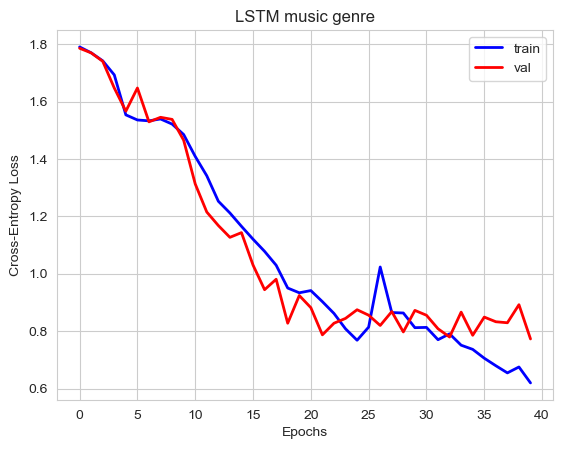

In [37]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM music genre')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

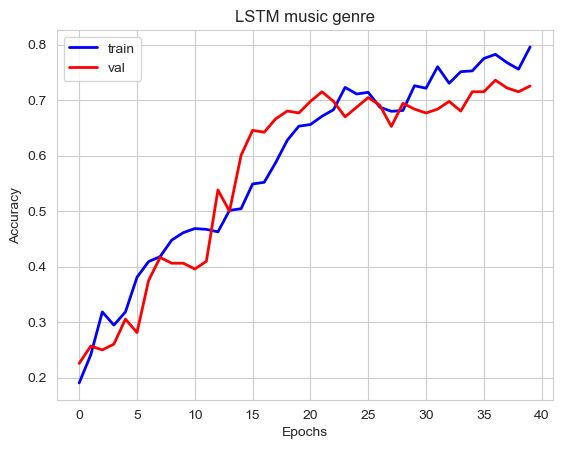

In [38]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM music genre')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

##### Submission

In [ ]:
predictions = model.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)
sample[['pred', "target"]]

import sklearn

print("Accuracy With fastText :")
print(sklearn.metrics.accuracy_score(sample.target, sample.pred))

In [ ]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()